In [8]:
#!/usr/bin/env python

import pandas as pd
import arff
from scipy.stats import gaussian_kde
from scipy.stats.distributions import uniform
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from arff2pandas import a2p

init_notebook_mode(connected=True)

In [31]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('results__2000__svc__predictive_accuracy.arff')
df = pd.DataFrame(data[0])

df.head()

columntransformer__numeric__imputer__strategy  predictive_accuracy  \
0                                     b'median'             0.679912   
1                              b'most_frequent'             0.522215   
2                                     b'median'             0.966834   
3                              b'most_frequent'             0.348561   
4                                     b'median'             0.522215   

         svc__C  svc__coef0  svc__degree  svc__gamma svc__kernel  \
0   4106.346087   -0.701720          NaN    0.101156  b'sigmoid'   
1      0.059314   -0.720285          3.0    0.000250     b'poly'   
2  15283.560563    0.908660          4.0    0.000042     b'poly'   
3    243.663224   -0.401704          2.0    0.000641     b'poly'   
4     32.914098   -0.486604          5.0    0.018313     b'poly'   

  svc__max_iter svc__shrinking  svc__tol  task_id  
0         b'-1'        b'True'  0.000038      3.0  
1         b'-1'        b'True'  0.006409      3.0  
2         b'-1'        b'True'  0.007772      3.0  
3         b'-1'       b'False'  0.001474      3.0  
4         b'-1'       b'False'  0.000637      3.0

In [32]:
for feature in list(df.dtypes[df.dtypes == 'object'].index):
    df[feature] = df[feature].astype(str)
    df[feature] = df[feature].str.replace("b'", "")
    df[feature] = df[feature].str.replace("'", "")
    

In [33]:
df.dtypes

columntransformer__numeric__imputer__strategy     object
predictive_accuracy                              float64
svc__C                                           float64
svc__coef0                                       float64
svc__degree                                      float64
svc__gamma                                       float64
svc__kernel                                       object
svc__max_iter                                     object
svc__shrinking                                    object
svc__tol                                         float64
task_id                                          float64
dtype: object

In [37]:
df.svc__max_iter = df.svc__max_iter.astype('float64')


In [38]:
df.head()

columntransformer__numeric__imputer__strategy  predictive_accuracy  \
0                                        median             0.679912   
1                                 most_frequent             0.522215   
2                                        median             0.966834   
3                                 most_frequent             0.348561   
4                                        median             0.522215   

         svc__C  svc__coef0  svc__degree  svc__gamma svc__kernel  \
0   4106.346087   -0.701720          NaN    0.101156     sigmoid   
1      0.059314   -0.720285          3.0    0.000250        poly   
2  15283.560563    0.908660          4.0    0.000042        poly   
3    243.663224   -0.401704          2.0    0.000641        poly   
4     32.914098   -0.486604          5.0    0.018313        poly   

   svc__max_iter svc__shrinking  svc__tol  task_id  
0           -1.0           True  0.000038      3.0  
1           -1.0           True  0.006409      3.0  
2           -1.0           True  0.007772      3.0  
3           -1.0          False  0.001474      3.0  
4           -1.0          False  0.000637      3.0

In [41]:
df = df.sort_values(by = ['task_id','predictive_accuracy'], ascending=False)
#df.head(10)

In [42]:
df['task_id'] = df['task_id'].astype('int64')

In [44]:
# Getting top 500 performance rows

filtered_df = df.groupby(['task_id']).head(500)

In [45]:
filtered_df.head()

columntransformer__numeric__imputer__strategy  predictive_accuracy  \
82175                                          mean                0.972   
83399                                        median                0.972   
82171                                          mean                0.970   
82196                                 most_frequent                0.970   
82488                                 most_frequent                0.970   

             svc__C  svc__coef0  svc__degree  svc__gamma svc__kernel  \
82175      0.052207    0.200932          1.0    3.373336        poly   
83399     78.184098    0.321450          NaN    0.002539     sigmoid   
82171   3328.544261    0.181425          NaN    0.000057     sigmoid   
82196  17353.584967   -0.816073          NaN    0.000062     sigmoid   
82488  32004.995080    0.103676          NaN    0.003041     sigmoid   

       svc__max_iter svc__shrinking  svc__tol  task_id  
82175           -1.0          False  0.001316     3567  
83399           -1.0           True  0.002437     3567  
82171           -1.0           True  0.000060     3567  
82196           -1.0           True  0.089525     3567  
82488           -1.0          False  0.017112     3567

In [46]:
sigmoid_df = filtered_df[filtered_df['svc__kernel'] == 'sigmoid']
rbf_df = filtered_df[filtered_df['svc__kernel'] == 'rbf']

In [47]:
class alt_gauss(gaussian_kde):
    
    def rvs(self, size = 1, random_state = None):
        res = self.resample(size)
        res = res[res>=0]
        res = res.reshape(-1,1)
        
        return res



## Playing around with KDEs

In [48]:
sci_sig_kde = alt_gauss(sigmoid_df['svc__gamma'].values, bw_method=1e-07)
sci_rbf_kde = alt_gauss(rbf_df['svc__gamma'], bw_method=1e-07)

In [49]:
from sklearn.neighbors.kde import KernelDensity
import numpy as np

X = np.array(sigmoid_df['svc__gamma']).reshape(-1,1)
sk_sig_kde = KernelDensity(kernel='gaussian', bandwidth=1e-07).fit(X)


In [50]:
sci_sig_kde.rvs(1)

array([[0.00018697]])

In [51]:
def plot_hist(x0, x1, start = None, end = None, size = None, color = None):
    #x0 = np.random.randn(500)
    #x1 = np.random.randn(500)+1

    trace1 = go.Histogram(
        x=x0,
        opacity=0.75,
        #histnorm='percent',
        name='control',
        xbins=dict(
            start=start,
            end=end,
            size=size
        ),
        marker=dict(
            color=color,
        )
    )
    if x1:
    
        trace2 = go.Histogram(
            x=x1,
            opacity=0.75
        )

        data = [trace1, trace2]
    
    else:
        data = [trace1]
    
    #layout = go.Layout(barmode='overlay')
    
    layout = go.Layout(
        barmode = 'overlay'#,
         #xaxis=dict(
         #    type='log',
         #    autorange=True
         #)#,
        #yaxis=dict(
        #    type='log',
        #    autorange=True
        #)
    )
    
    
    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='overlaid histogram')

In [52]:
plot_hist(x0 = df['predictive_accuracy'][df['task_id'] == 3567.0], x1 = None, start = 0.9, end = 1, size = 0.001)

KeyError: 'predictive_accuracy@NUMERIC'

In [20]:
plot_hist(x0 = df['svc__gamma'], x1 = None, start=0, end = 0.1, size = 0.001)

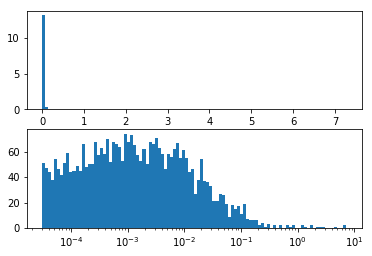

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = sigmoid_df['svc__gamma']
x = pd.Series(x)

#x

# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=100, density=True)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
#plt.subplot(211)
#plt.hist(y, bins=logbins)
plt.xscale('log')
plt.show()

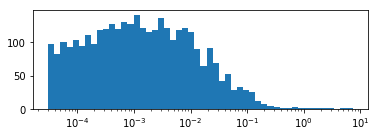

In [110]:
plot_log_hist(sigmoid_df['svc__gamma'])

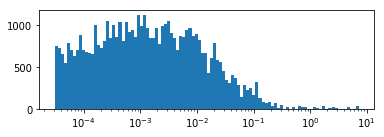

In [111]:
plot_log_hist(sci_sig_kde.rvs(50000), bins=100)

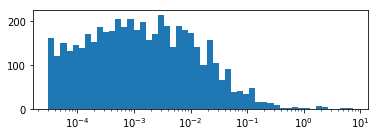

In [112]:
plot_log_hist(sk_sig_kde.sample(5000))

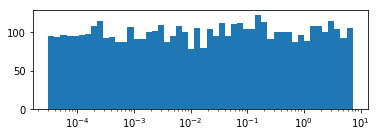

In [113]:
lu = loguni(low = np.log10(min(sigmoid_df['svc__gamma'])), high = np.log10(max(sigmoid_df['svc__gamma'])), base = 10)
plot_log_hist(lu.rvs(size=5000))

In [92]:
np.log10(min(sigmoid_df['svc__gamma']))

-4.513589357539095

In [93]:
np.log10(max(sigmoid_df['svc__gamma']))

0.8616562985076849

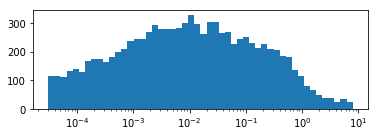

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = rbf_df['svc__gamma']
x = pd.Series(x)



# histogram on linear scale
#plt.subplot(211)
hist, bins, _ = plt.hist(x, bins=50)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show()

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_log_hist(x, bins = 50, show_linear = False):
    
    #x = sigmoid_df['svc__gamma']
    x = np.array(x)

    #x

    # histogram on linear scale
    if show_linear:
        plt.subplot(211)
    
    hist, bins, _ = plt.hist(x, bins=bins, density=True)

    # histogram on log scale. 
    # Use non-equal bin sizes, such that they look equal on log scale.
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    #plt.subplot(211)
    #plt.hist(y, bins=logbins)
    plt.xscale('log')
    plt.show()


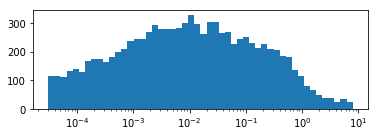

In [24]:
plot_log_hist(x = rbf_df['svc__gamma'] )

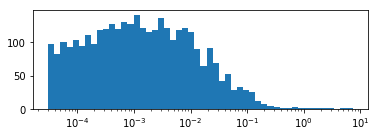

In [25]:
plot_log_hist(x = sigmoid_df['svc__gamma'])

In [26]:
kde.sample(20000).shape

(20000, 1)

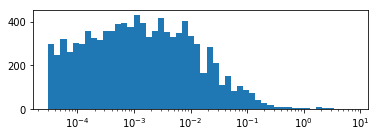

In [27]:
kde.fit(np.array(sigmoid_df['svc__gamma']).reshape(-1,1))

class alternative_kde(KernelDensity):
    
    def rvs(self, num = 1, random_state = None):
        res = self.sample(num)
        res = res[res>=0]
        res = res.reshape(-1,1)
        
        return res

kde.rvs = kde.sample

 

X = np.array(sigmoid_df['svc__gamma']).reshape(-1,1)
sig_kde = alternative_kde(kernel='gaussian', bandwidth=1e-07).fit(X)
X = np.array(rbf_df['svc__gamma']).reshape(-1,1)
rbf_kde = alternative_kde(kernel='gaussian', bandwidth=1e-07).fit(X)


z = sig_kde.rvs(10000)
#z = z[z>0]
plot_log_hist(x=z)

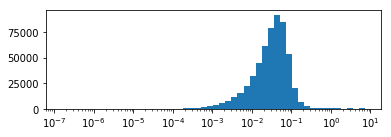

In [28]:
z = sci_sig_kde.rvs(1000000)
#z = z[z>0]
plot_log_hist(x=z)

In [29]:
sig_kde = gaussian_kde(sigmoid_df['svc__gamma'])
rbf_kde = gaussian_kde(rbf_df['svc__gamma'])

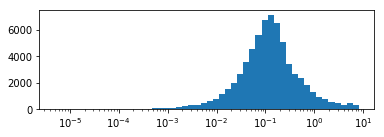

In [32]:
z = sci_rbf_kde.rvs(size=100000)
plot_log_hist(x = z)

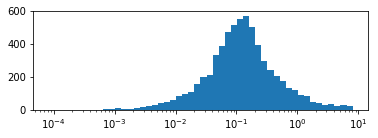

In [33]:
z = sci_rbf_kde.rvs(10000)
#z = z[z>0]
plot_log_hist(x=z)

In [52]:
def lognuniform(low=0, high=1, size=None, base=np.e):
    return np.power(base, np.random.uniform(low, high, size))

In [55]:
luni = lognuniform(low = -1, high = 3, base = 10, size = 100)

In [160]:
class loguni():
    def __init__(self, low, high, base = 10):
        self.low = low
        self.high = high
        self.base = base
        
    def rvs(self, size = 1, random_state = None):
        #def rvs(self, num = 1, random_state = None):
        temp = np.power(self.base, np.random.uniform(self.low, self.high, size))
        #res = self.sample(num)
        res = temp
        #res = res[res>=0]
        res = res.reshape(-1,1)

        return res
    
    

        

    

### Now that the distributions have been verified we can proceed to check the performance changes

In [58]:
lu = loguni(low = -1, high = 3, base = 10)

In [59]:
lu.rvs(size=10)

array([[3.57615887e-01],
       [1.88189014e-01],
       [1.32749749e+02],
       [4.64136456e-01],
       [8.98758670e-01],
       [5.80851861e+01],
       [9.06570507e+02],
       [4.94675349e+01],
       [3.46625622e-01],
       [4.27007512e+01]])

In [61]:
min(z)

array([8.16243914e-05])

In [62]:
max(z)

array([8.08007335])

# OpenML data download

In [36]:
import openml
from sklearn import preprocessing, tree, pipeline


In [37]:
task = openml.tasks.get_task(31)

In [38]:
dataset = task.get_X_and_y()

In [39]:
dataset[0].shape

(1000, 20)

In [40]:
dataset[1].shape

(1000,)

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import VarianceThreshold
#import ConfigSpace
import importlib


In [42]:
def get_filtered_tasks(file = 'results__2000__svc__predictive_accuracy.arff', top_n = 500):
    #data = arff.load(open('results__2000__svc__predictive_accuracy.arff'))
    with open(data) as f:
        df = a2p.load(f)
    #print(df)
    df = df.sort_values(by = ['task_id','predictive_accuracy'], ascending=False)
    filtered_df = df.groupby(['task_id']).head(top_n)
    return filtered_df


    
    

In [43]:
from scipy.stats import uniform

In [44]:
max(sigmoid_df['svc__gamma'])

7.272040660433016

In [45]:
uniform_sig = uniform(loc = min(sigmoid_df['svc__gamma']), scale = max(sigmoid_df['svc__gamma']))
uniform_rbf = uniform(loc = min(rbf_df['svc__gamma']), scale = max(rbf_df['svc__gamma']))

In [51]:
uni = uniform(loc = 1, scale = 10)
uni.rvs(size = 50)

array([ 7.95523997,  6.08572408,  7.94235752,  4.80830227,  7.99578787,
        4.02914056,  3.66138328,  5.40115951,  5.16270806,  3.02254007,
        8.99765755,  2.79400605,  1.63148606,  5.69156771,  3.33325342,
        3.17562863,  5.33393562, 10.55789652,  6.75817199,  7.72388915,
        9.53443425,  5.94906922,  6.79320783,  1.36204927,  4.0163661 ,
        9.78767905,  5.06287612,  5.38325033,  2.68846389,  1.58705407,
        1.23994398,  5.11964931, 10.34921755,  3.6553254 ,  7.6153693 ,
        8.40653489, 10.16494481,  8.7844527 ,  1.60292769,  1.80111614,
        8.94960639,  4.03862649,  7.5467603 ,  7.10351494,  7.95667876,
        3.76216715,  5.58759755,  3.89496976,  7.51954891,  4.50662717])

In [ ]:
def lognuniform(low=0, high=1, size=None, base=np.e):
    return np.power(base, np.random.uniform(low, high, size))

In [162]:
#def test_model(task_id = 31)

task = openml.tasks.get_task(31)

dataset = task.get_X_and_y()

X = dataset[0]
y = dataset[1]





nominal_indices = task.get_dataset().get_features_by_type('nominal', [task.target_name])

numeric_indices = task.get_dataset().get_features_by_type('numeric', [task.target_name])

numeric_transformer = make_pipeline(
    Imputer(),
    StandardScaler())

# note that the dataset is encoded numerically, hence we can only impute
# numeric values, even for the categorical columns. 
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=-1),
    OneHotEncoder(handle_unknown='ignore'))

transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_indices),
        ('nominal', categorical_transformer, nominal_indices)],
    remainder='passthrough')



clf = make_pipeline(transformer, VarianceThreshold(), SVC())


kde = uniform(loc=1, scale = 10)


param_dist_kernel = {
    'svc__gamma' : sci_sig_kde,
    'svc__kernel': ['sigmoid']
}

param_dist_uniform = {
    'svc__gamma' : loguni(low = np.log10(min(sigmoid_df['svc__gamma'])), high = np.log10(max(sigmoid_df['svc__gamma'])), base = 10) ,
    'svc__kernel': ['sigmoid']
}




rs_kernel = RandomizedSearchCV(
  estimator=clf,
  param_distributions = param_dist_kernel,
  n_iter=20
)

rs_uniform = RandomizedSearchCV(
  estimator=clf,
  param_distributions = param_dist_uniform,
  n_iter=20
)




/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.



In [149]:
X.shape

(1000, 20)

In [150]:
y.shape

(1000,)

In [151]:
sigmoid_df['svc__gamma'].values

array([2.53932131e-03, 5.73425886e-05, 6.24183639e-05, ...,
       6.17211899e-03, 4.03178398e-04, 2.70396503e-03])

In [165]:
k_score = cross_val_score(X=X, y=y, cv = 3, estimator=rs_kernel)

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import i

In [166]:
uni_score = cross_val_score(X=X, y=y, cv = 3, estimator=rs_uniform)

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.

/Users/adi/anaconda3/envs/automl/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning:

Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import i

In [167]:
print(k_score, uni_score)

[0.73652695 0.74474474 0.72072072] [0.73652695 0.6966967  0.75675676]


In [42]:
uni = uniform(loc = 0, scale = 7)

In [43]:
uni.rvs(size=20)

array([6.20278483, 0.11019433, 0.13545126, 6.10093659, 2.50134978,
       0.68391889, 2.96995846, 1.89484092, 6.64328511, 0.65667171,
       5.37273442, 4.8472113 , 0.95641662, 5.36383201, 1.64596792,
       1.43464924, 6.43686049, 1.82722644, 4.1110551 , 1.31442731])

## Looping through all tasks